# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import covid19 as covid
import finananal as finan

from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from datetime import timedelta, datetime

# Constants

In [2]:
COVID19_CONFIRMED_CASES = '/home/marcelo/Documents/IA/COVID19_2303/time_series_covid_19_confirmed.csv'
COVID19_DEATHS = '/home/marcelo/Documents/IA/COVID19_2303/time_series_covid_19_deaths.csv'
COVID19_RECOVERED = '/home/marcelo/Documents/IA/COVID19_2303/time_series_covid_19_recovered.csv'

# Get the info

In [3]:
covid19_cases = pd.read_csv(COVID19_CONFIRMED_CASES)
covid19_deaths = pd.read_csv(COVID19_DEATHS)
covid19_recover = pd.read_csv(COVID19_RECOVERED)

In [4]:
covid19_deaths

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20
0,NaN,Afghanistan,33.000000,65.000000,0,0,0,0,0,0,...,0,0,0,0,0,1,1,1,2,4
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,...,1,2,2,2,2,2,4,5,5,6
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,4,7,9,11,15,17,17,19,21,25
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,0,0,0,0,0,1,1,1,1,3
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243,NaN,Mali,17.570692,-3.996166,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
244,NaN,Saint Kitts and Nevis,17.357822,-62.782998,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
245,Northwest Territories,Canada,64.825500,-124.845700,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
246,Yukon,Canada,64.282300,-135.000000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
def index_date(df, start_ind = 4):
    
    dates = df.columns[start_ind:].values
    current = []
    
    for d in dates:
        current.append(datetime.strptime(d, '%m/%d/%y'))
        
    return current

In [6]:
def date_index(df, country, index):
    
    number_cases = covid.data_cleaner(df, country, min_cases = 0)
    cases_date = pd.DataFrame(number_cases.to_numpy(), index = index)
    
    return cases_date

In [7]:
def country_data(country, index):
    
    country_data = pd.DataFrame(columns= ['cases', 'recover', 'deaths','removed'], index = index)
    country_data['cases'] = date_index(covid19_cases, country, index = index)
    country_data['recover'] = date_index(covid19_recover, country, index = index)
    country_data['deaths'] = date_index(covid19_deaths, country, index = index)
    country_data['removed'] = country_data.recover + country_data.deaths
    
    return country_data

In [8]:
def loss(params, cases, removed, S_0, I_0, R_0, population):

    size = len(cases)
    beta, gamma = params

    def SIR(t, y):
        S = y[0]
        I = y[1]
        R = y[2]
        return [-beta*S*I/population, beta*S*I-gamma*I/population, gamma*I]
    
    solution = solve_ivp(SIR, [0, size], [S_0,I_0,R_0], t_eval=np.arange(0, size, 1), vectorized=True)
    l1 = np.sqrt(np.mean((solution.y[1] - cases)**2))
    l2 = np.sqrt(np.mean((solution.y[2] - removed)**2))
    alpha = 0.1

    return alpha * l1 + (1 - alpha) * l2

In [9]:
current = index_date(covid19_cases, start_ind = 4)

# beta gamma finder func

In [10]:
# min_cases = 1
# multiplier = 1
# size_chunk = 7

In [11]:
def beta_gamma_finder(cases, removed, chunk, population, S_0=10000, I_0=0, R_0=0, size_chunk=7):
        
    s_vect=[]
    i_vect=[]
    r_vect=[]
    
    chunk = int(np.floor(len(cases)/size_chunk))
    params_hist=pd.DataFrame(columns = ['beta', 'gamma'], index = range(chunk))
    sir = pd.DataFrame(columns = ['date','pop', 'inf', 'rem'])
    
    beta = 0.0000001
    gamma = 0.001
    for i in range(chunk):
            
#         beta = 0.00001
#         gamma = 0.00001
        low = i*size_chunk
        high = (i+1)*size_chunk-1
        cases_chunk = cases[low:high]
        removed_chunk = removed[low:high]
        
        optimal = minimize(loss, [beta, gamma], 
                           args=(cases, removed, S_0, I_0, R_0, population), 
                           method='L-BFGS-B', 
                           bounds=[(0.0000001, 0.5), (0.00001, 1)])
        
        print(f'gamma, beta week {i}', optimal.x)
        params_hist.iloc[i] = optimal.x
        beta = params_hist.beta[i]
        gamma = params_hist.gamma[i]
        
        def SIR(t,y_hat):
            S = y_hat[0]
            I = y_hat[1]
            R = y_hat[2]
            return [-beta*S*I/population, beta*S*I-gamma*I/population, gamma*I]
        
        solution = solve_ivp(SIR, 
                             [0, size_chunk+1], 
                             [S_0,I_0,R_0], 
                             t_eval=np.arange(0, size_chunk+1, 1), 
                             vectorized=True)
        
        s_vect = np.concatenate((s_vect, solution.y[0][:size_chunk]))
        i_vect = np.concatenate((i_vect, solution.y[1][:size_chunk]))
        r_vect = np.concatenate((r_vect, solution.y[2][:size_chunk]))
        S_0 = solution.y[0][size_chunk]
        I_0 = solution.y[1][size_chunk]
        R_0 = solution.y[2][size_chunk]
        print(f'week {i} y', cases_chunk.to_numpy())
        print(f'week {i} y_hat', np.floor(solution.y[1][:size_chunk]))
    
    date_index = pd.date_range(cases.index[0], periods=(len(s_vect)), freq='D')
    sir['pop'] = s_vect
    sir['inf'] = i_vect
    sir['rem'] = r_vect
    sir['date'] = date_index
#     sir = sir[size_chunk:]
    return sir, params_hist
    

In [12]:
def trainer(df, norm = False, population = 10000, min_cases = 1, multiplier = 1, size_chunk = 7):
    
    S_0 = population
    
    current = index_date(covid19_cases, start_ind = 4)
    df = data[data.cases>=min_cases]
    df_norm = finan.normalize(df)
    
    if norm == False:
        df = df
        cases = df.cases*multiplier
        recovered = df.recover*multiplier
        deaths = df.deaths*multiplier
        removed = df.removed*multiplier
    else:
        df = finan.normalize(df)
        cases = df_norm.cases*multiplier
        recovered = df_norm.recover*multiplier
        deaths = df_norm.deaths*multiplier
        removed = df_norm.removed*multiplier
        
    sir, params_hist = beta_gamma_finder(cases, removed, chunk = 7, 
                                         population= population,
                                         S_0= population, 
                                         I_0 = cases[0], 
                                         R_0 = removed[0]
                                        )
#     sir = sir[size_chunk:]
    plt.plot(sir['inf'], color = 'orange')
    plt.plot(cases[:len(sir)].values, color = 'red')
#     plt.plot(sir['rem'], color = 'black')
#     plt.plot(sir['pop'], color = 'green')
    plt.xlim(0, len(sir))
    plt.ylim(0, cases[:len(sir)].max())
    plt.show()
    
    return sir, params_hist, df

In [13]:
def predictor(sir, params_hist, DFN):

    
    last_data = sir.tail(1).to_numpy()
    
    
    
    beta = params_hist.beta[len(params_hist)-1]
    gamma = params_hist.gamma[len(params_hist)-1]
    
    S_0 = last_data[0][1]
    I_0 = last_data[0][2]
    R_0 = last_data[0][3]
    population = S_0
    
    date_index_pred = pd.date_range(sir.date[0], periods=DFN, freq='D')
    
    def SIR(t,y_hat):
        S = y_hat[0]
        I = y_hat[1]
        R = y_hat[2]
        return [-beta*S*I/population, beta*S*I-gamma*I/population, gamma*I]
    
    solution = solve_ivp(SIR, 
                         [0, DFN], 
                         [S_0,I_0,R_0], 
                         t_eval=np.arange(0, DFN, 1), 
                         vectorized=True)
    
    sir2 = pd.DataFrame(columns = ['date','pop', 'inf', 'rem'], 
                        index = range(len(sir),(len(sir)+DFN),1))
    
    sir2['pop'] = solution.y[0]
    sir2['inf'] = solution.y[1]
    sir2['rem'] = solution.y[2]
    sir2['date'] = date_index_pred
    
    frames = [sir,sir2]
    sir_pred = pd.concat(frames)
    sir_pred
    
#     plt.plot(sir_pred['pop'])
#     plt.plot(sir_pred['inf'])
#     plt.plot(sir_pred['rem'])
#     plt.show()
    return sir_pred

In [14]:
def predictor_manual(S_0, I_0, R_0, params_hist, DFN):
        
    population = S_0
    beta = params_hist[0]
    gamma = params_hist[1]
    
    date_index_pred = pd.date_range(cases.index[0], periods=DFN, freq='D')
    
    def SIR(t,y_hat):
        S = y_hat[0]
        I = y_hat[1]
        R = y_hat[2]
        return [-beta*S*I/population, beta*S*I-gamma*I/population, gamma*I]
    
    solution = solve_ivp(SIR, 
                         [0, DFN], 
                         [S_0,I_0,R_0], 
                         t_eval=np.arange(0, DFN, 1), 
                         vectorized=True)
    
    sir2 = pd.DataFrame(columns = ['date','pop', 'inf', 'rem'], 
                        index = range(0,(DFN),1))
    
    sir2['pop'] = solution.y[0]
    sir2['inf'] = solution.y[1]
    sir2['rem'] = solution.y[2]
    sir2['date'] = date_index_pred
    
    frames = [sir,sir2]
    sir_pred = pd.concat(frames)
    sir_pred
    
#     plt.plot(sir_pred['pop'])
#     plt.plot(sir_pred['inf'])
#     plt.plot(sir_pred['rem'])
#     plt.show()
    return sir2

In [15]:
data = country_data(country='France', index=current)
data

,cases,recover,deaths,removed
2020-01-22,0,0,0,0
2020-01-23,0,0,0,0
2020-01-24,2,0,0,0
2020-01-25,3,0,0,0
2020-01-26,3,0,0,0
...,...,...,...,...
2020-03-22,16243,2206,676,2882
2020-03-23,20123,2206,862,3068
2020-03-24,22622,3250,1102,4352
2020-03-25,25600,3907,1333,5240


In [16]:
# sir, params_hist, df = trainer(data, population = 10000, min_cases = 100, norm=False)

In [17]:
# plt.plot(params_hist.beta, params_hist.gamma)
# plt.xlabel('beta')
# plt.ylabel('gamma')
# plt.show()

In [18]:
# sir_pred = predictor(sir,params_hist, DFN = 70)
# plt.plot((sir_pred.inf.head(35).values)[10:])
# plt.plot(df.cases.head(60).values)

In [19]:
# data

In [20]:
# plt.plot((sir_pred.inf.head(120).values)[10:])
# plt.plot(df.cases.head(60).values)

In [21]:
country = covid19_cases['Country/Region'].unique()
country

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Benin', 'Bhutan', 'Bolivia',
       'Bosnia and Herzegovina', 'Brazil', 'Brunei', 'Bulgaria',
       'Burkina Faso', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Diamond Princess', 'Cuba', 'Cyprus',
       'Czechia', 'Denmark', 'Djibouti', 'Dominican Republic', 'Ecuador',
       'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France', 'Gabon',
       'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Guatemala',
       'Guinea', 'Guyana', 'Haiti', 'Holy See', 'Honduras', 'Hungary',
       'Iceland', 'India

simulation for: Afghanistan
Not enough data
simulation for: Albania
Not enough data
simulation for: Algeria
Not enough data
simulation for: Andorra
Not enough data
simulation for: Angola
Not enough data
simulation for: Antigua and Barbuda
Not enough data
simulation for: Argentina


/home/marcelo/environments/JUPYTER/jupyter_anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.


gamma, beta week 0 [1.56966234e-06 4.04353609e-02]
week 0 y [128 158 266 301 387 387]
week 0 y_hat [128. 161. 204. 259. 328. 415. 525.]


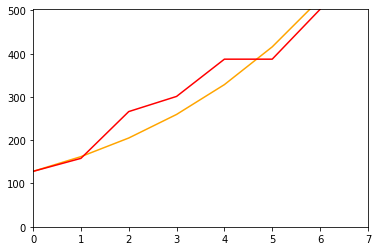

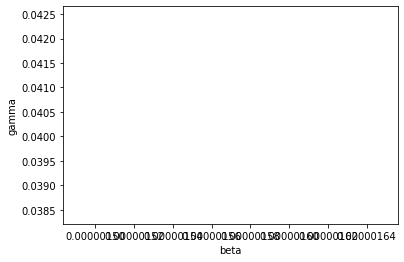

simulation for: Armenia
gamma, beta week 0 [9.51960276e-07 1.19234794e-02]
week 0 y [115 136 160 194 235 249]
week 0 y_hat [115. 132. 153. 176. 203. 234. 270.]


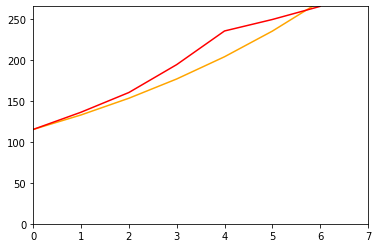

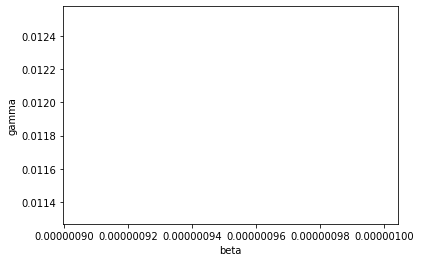

simulation for: Australia
gamma, beta week 0 [1.37892249e-06 1.00320712e-02]
week 0 y [107 128 128 200 250 297]
week 0 y_hat [107. 131. 161. 199. 244. 300. 370.]
gamma, beta week 1 [6.83094973e-07 4.40772940e-03]
week 1 y [452 568 681 791 1071 1549]
week 1 y_hat [455. 504. 558. 618. 685. 759. 841.]


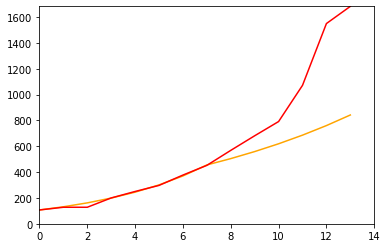

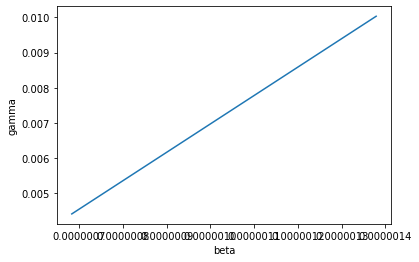

simulation for: Austria
gamma, beta week 0 [1.59025472e-06 1.00297753e-03]
week 0 y [104 131 182 246 302 504]
week 0 y_hat [104. 132. 167. 212. 270. 342. 435.]
gamma, beta week 1 [9.08676472e-07 1.71679030e-03]
week 1 y [860 1018 1332 1646 2013 2388]
week 1 y_hat [ 552.  633.  725.  831.  952. 1091. 1251.]


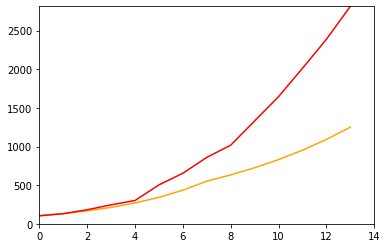

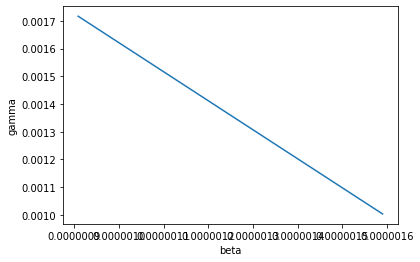

simulation for: Azerbaijan
Not enough data
simulation for: Bahamas
Not enough data
simulation for: Bahrain
gamma, beta week 0 [5.86386725e-07 4.97280097e-02]
week 0 y [110 195 195 195 210 214]
week 0 y_hat [110. 120. 131. 143. 156. 170. 186.]
gamma, beta week 1 [3.00365245e-07 2.01094754e-02]
week 1 y [228 256 278 285 305 334]
week 1 y_hat [203. 212. 222. 233. 243. 255. 266.]


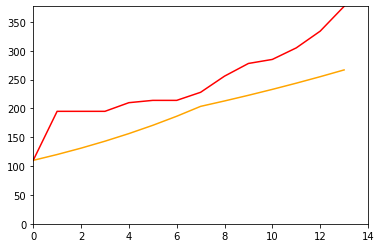

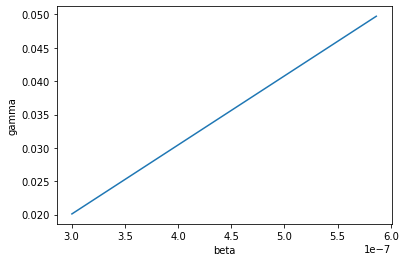

simulation for: Bangladesh
Not enough data
simulation for: Barbados
Not enough data
simulation for: Belarus
Not enough data
simulation for: Belgium
gamma, beta week 0 [1.36100994e-06 2.60167916e-02]
week 0 y [109 169 200 239 267 314]
week 0 y_hat [109. 133. 163. 201. 246. 302. 371.]
gamma, beta week 1 [8.32956719e-07 1.43010060e-02]
week 1 y [559 689 886 1058 1243 1486]
week 1 y_hat [455. 515. 584. 662. 750. 849. 963.]
gamma, beta week 2 [4.83352566e-07 7.37311756e-03]
week 2 y [2257 2815 3401 3743 4269 4937]
week 2 y_hat [1091. 1173. 1261. 1356. 1458. 1567. 1685.]


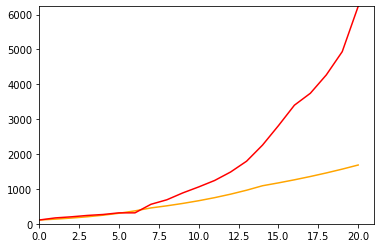

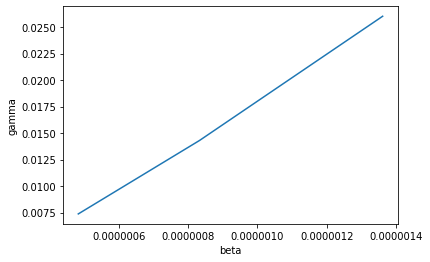

simulation for: Benin
Not enough data
simulation for: Bhutan
Not enough data
simulation for: Bolivia
Not enough data
simulation for: Bosnia and Herzegovina
Not enough data
simulation for: Brazil
gamma, beta week 0 [1.57312009e-06 6.00225134e-03]
week 0 y [151 151 162 200 321 372]
week 0 y_hat [151. 191. 242. 306. 388. 491. 622.]
gamma, beta week 1 [5.69767368e-07 1.92961808e-03]
week 1 y [793 1021 1546 1924 2247 2554]
week 1 y_hat [ 787.  857.  934. 1017. 1108. 1207. 1315.]


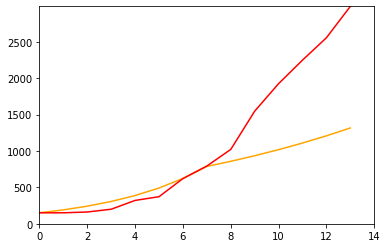

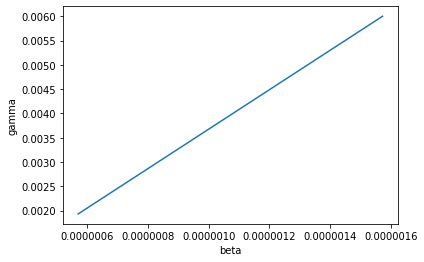

simulation for: Brunei
Not enough data
simulation for: Bulgaria
Not enough data
simulation for: Burkina Faso
Not enough data
simulation for: Cabo Verde
Not enough data
simulation for: Cambodia
Not enough data
simulation for: Cameroon
Not enough data
simulation for: Canada
gamma, beta week 0 [1.62254053e-06 1.17707054e-02]
week 0 y [108 117 193 198 252 415]
week 0 y_hat [108. 137. 175. 224. 285. 364. 465.]
gamma, beta week 1 [7.49295351e-07 4.57971922e-03]
week 1 y [657 800 943 1277 1469 2088]
week 1 y_hat [ 593.  663.  742.  831.  930. 1040. 1164.]


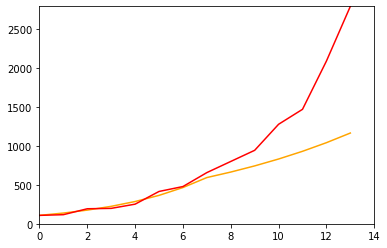

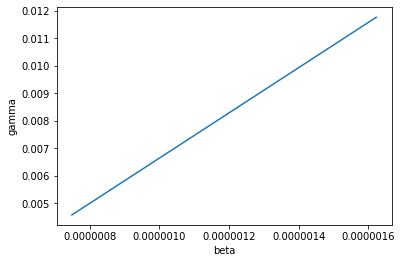

simulation for: Central African Republic
Not enough data
simulation for: Chad
Not enough data
simulation for: Chile
gamma, beta week 0 [1.45873474e-06 4.99286854e-03]
week 0 y [155 201 238 238 434 537]
week 0 y_hat [155. 192. 240. 298. 371. 462. 576.]


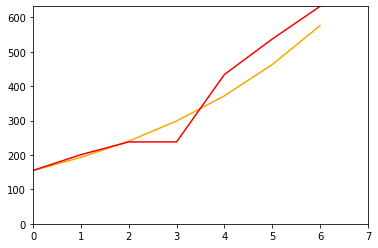

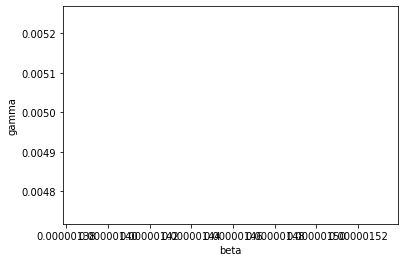

simulation for: China
gamma, beta week 0 [1.e-07 1.e-03]
week 0 y [548 643 920 1406 2075 2877]
week 0 y_hat [548. 556. 564. 573. 581. 590. 599.]
gamma, beta week 1 [1.e-07 1.e-03]
week 1 y [6087 8141 9802 11891 16630 19716]
week 1 y_hat [608. 617. 627. 636. 646. 656. 665.]
gamma, beta week 2 [1.e-07 1.e-03]
week 2 y [27440 30587 34110 36814 39829 42354]
week 2 y_hat [676. 686. 696. 707. 717. 728. 739.]
gamma, beta week 3 [1.e-07 1.e-03]
week 3 y [44759 59895 66358 68413 70513 72434]
week 3 y_hat [750. 762. 773. 785. 797. 809. 821.]
gamma, beta week 4 [1.e-07 1.e-03]
week 4 y [74619 75077 75550 77001 77022 77241]
week 4 y_hat [834. 846. 859. 872. 885. 898. 912.]
gamma, beta week 5 [1.e-07 1.e-03]
week 5 y [78166 78600 78928 79356 79932 80136]
week 5 y_hat [ 926.  940.  954.  969.  983.  998. 1013.]
gamma, beta week 6 [1.e-07 1.e-03]
week 6 y [80386 80537 80690 80770 80823 80860]
week 6 y_hat [1028. 1044. 1060. 1076. 1092. 1109. 1125.]
gamma, beta week 7 [1.e-07 1.e-03]
week 7 y [80921 8

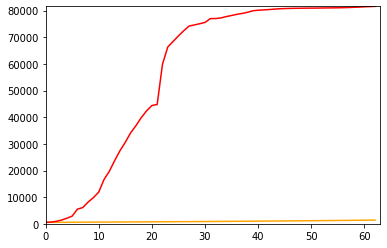

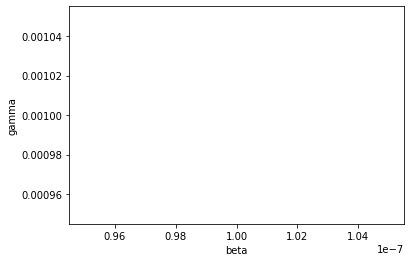

simulation for: Colombia
gamma, beta week 0 [1.59149163e-06 7.46159585e-03]
week 0 y [102 128 196 231 277 378]
week 0 y_hat [102. 129. 164. 208. 265. 336. 427.]


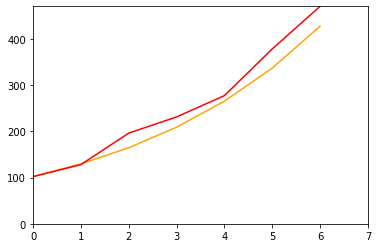

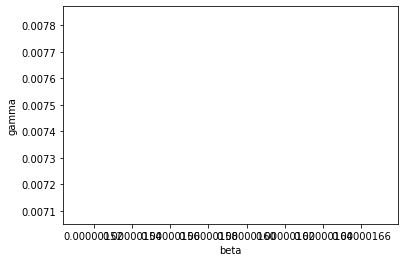

simulation for: Congo (Brazzaville)
Not enough data
simulation for: Congo (Kinshasa)
Not enough data
simulation for: Costa Rica
Not enough data
simulation for: Cote d'Ivoire
Not enough data
simulation for: Croatia
gamma, beta week 0 [1.56571041e-06 8.21857513e-03]
week 0 y [105 128 206 254 315 382]
week 0 y_hat [105. 132. 167. 212. 268. 339. 429.]


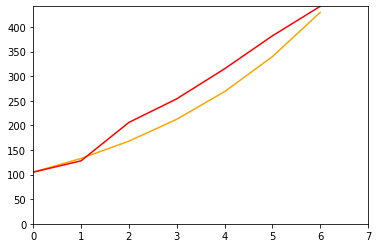

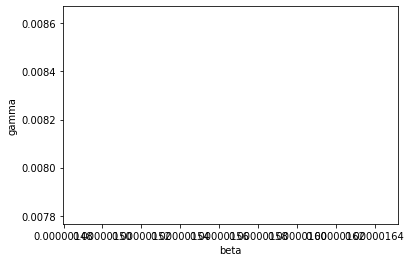

simulation for: Diamond Princess
gamma, beta week 0 [3.15538401e-07 2.19528402e-02]
week 0 y [135 135 175 175 218 285]
week 0 y_hat [135. 141. 148. 155. 163. 171. 179.]
gamma, beta week 1 [2.61835718e-07 1.73674476e-02]
week 1 y [454 542 621 634 634 634]
week 1 y_hat [188. 195. 203. 211. 220. 228. 237.]
gamma, beta week 2 [2.14569382e-07 1.35698962e-02]
week 2 y [691 691 705 705 705 705]
week 2 y_hat [247. 255. 263. 272. 281. 290. 300.]
gamma, beta week 3 [1.71975694e-07 1.06134707e-02]
week 3 y [705 706 706 706 706 706]
week 3 y_hat [310. 318. 326. 335. 343. 352. 361.]
gamma, beta week 4 [1.31150672e-07 8.34125267e-03]
week 4 y [706 706 706 706 706 706]
week 4 y_hat [371. 378. 386. 394. 401. 409. 417.]
gamma, beta week 5 [1.03138026e-07 6.45380772e-03]
week 5 y [706 706 712 712 712 712]
week 5 y_hat [426. 432. 439. 446. 453. 460. 467.]


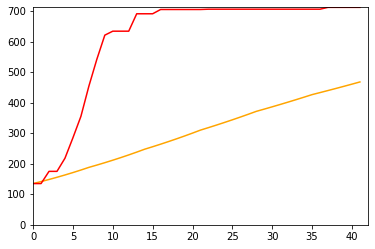

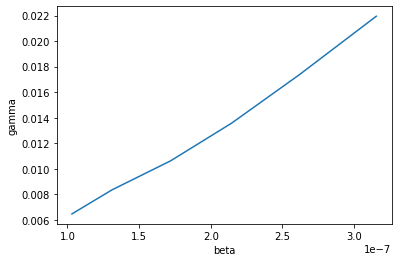

simulation for: Cuba
Not enough data
simulation for: Cyprus
Not enough data
simulation for: Czechia
gamma, beta week 0 [1.38434300e-06 1.00256614e-03]
week 0 y [141 189 253 298 396 464]
week 0 y_hat [141. 173. 213. 262. 323. 398. 490.]
gamma, beta week 1 [4.96832077e-07 9.02545077e-04]
week 1 y [833 995 1120 1236 1394 1654]
week 1 y_hat [603. 649. 700. 754. 812. 875. 943.]


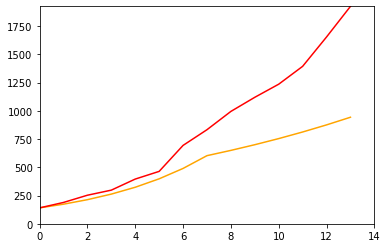

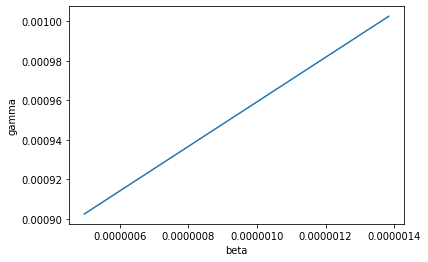

simulation for: Denmark
gamma, beta week 0 [9.08293160e-07 1.00161499e-03]
week 0 y [264 444 617 804 836 875]
week 0 y_hat [264. 302. 346. 397. 455. 521. 597.]
gamma, beta week 1 [4.34032954e-07 2.64231170e-03]
week 1 y [1025 1116 1225 1337 1420 1514]
week 1 y_hat [ 685.  731.  780.  832.  888.  948. 1012.]


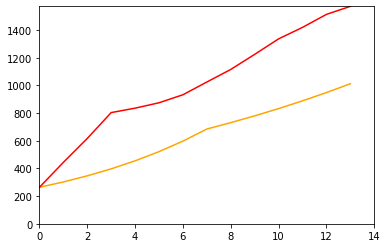

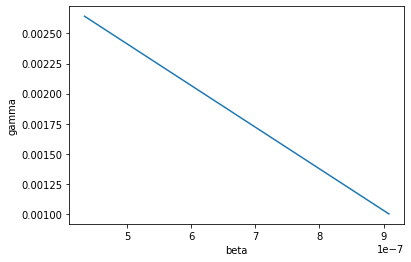

simulation for: Djibouti
Not enough data
simulation for: Dominican Republic
Not enough data
simulation for: Ecuador
gamma, beta week 0 [2.24718811e-06 1.00429014e-03]
week 0 y [111 199 367 506 789 981]
week 0 y_hat [111. 155. 217. 305. 427. 598. 838.]


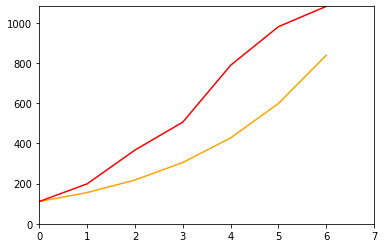

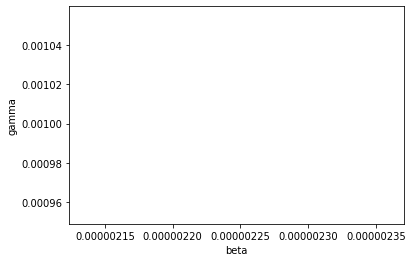

simulation for: Egypt
gamma, beta week 0 [8.82047359e-07 2.83977551e-02]
week 0 y [109 110 150 196 196 256]
week 0 y_hat [109. 124. 142. 162. 185. 211. 241.]


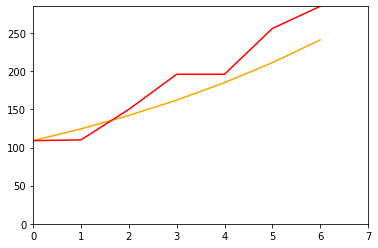

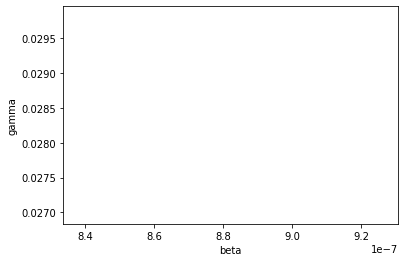

simulation for: El Salvador
Not enough data
simulation for: Equatorial Guinea
Not enough data
simulation for: Eritrea
Not enough data
simulation for: Estonia
gamma, beta week 0 [8.33994976e-07 2.41813108e-03]
week 0 y [115 171 205 225 258 267]
week 0 y_hat [115. 130. 147. 167. 189. 214. 243.]


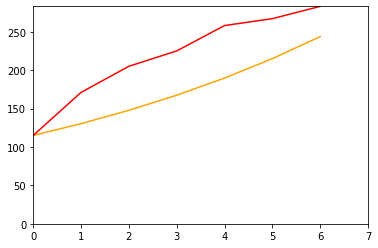

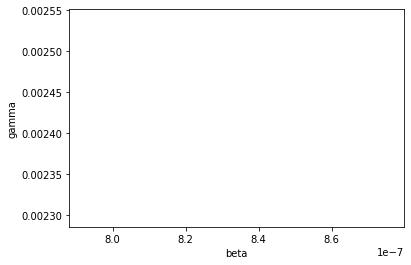

simulation for: Eswatini
Not enough data
simulation for: Ethiopia
Not enough data
simulation for: Fiji
Not enough data
simulation for: Finland
gamma, beta week 0 [9.64950773e-07 2.93033909e-03]
week 0 y [155 225 244 277 321 336]
week 0 y_hat [155. 179. 207. 239. 276. 319. 369.]
gamma, beta week 1 [3.12477669e-07 9.93444078e-04]
week 1 y [450 523 626 700 792 880]
week 1 y_hat [426. 447. 468. 491. 514. 539. 565.]


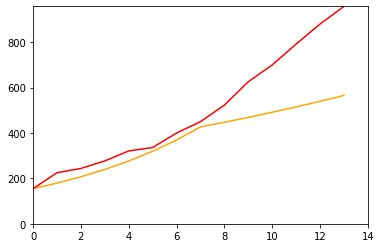

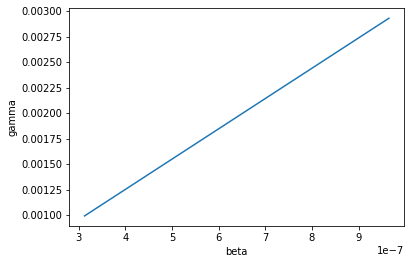

simulation for: France


In [ ]:
for i in country:
    sir_dict = {'country': country}
    params_hist_dict = {'country': country}
    df_dict = {'country': country}
    data = country_data(country=i, index=current)
    print('simulation for:', i)
    try:

        sir, params_hist, df = trainer(data, population = 150000, 
                                       min_cases = 100, norm=False)
        sir_dict[i] = sir
        params_hist_dict[i] = params_hist
        df_dict[i] = df
        plt.plot(params_hist.beta, params_hist.gamma)
        plt.xlabel('beta')
        plt.ylabel('gamma')
        plt.show()
#         sir_pred = predictor(sir,params_hist, DFN = 70)
#         plt.plot((sir_pred.inf.head(35).values)[10:])
#         plt.plot(df.cases.head(60).values)
#         plt.show()
    except:
        print('Not enough data')

In [ ]:
params_hist_dict